In [1]:
import os 
os.getcwd()

'/home/m/repo/ThinkBayes2/mine'

In [2]:
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pyplot as plt



In [3]:
# Generate synthetic time series data (same as before)
np.random.seed(42)
n_data_points = 100
start_date = '2020-01-01'
end_date = '2020-04-09'
linear_trend_slope = 0.3
noise_std_dev = 2
date_range = pd.date_range(start=start_date, end=end_date, periods=n_data_points)
linear_trend = np.arange(n_data_points) * linear_trend_slope
noise = np.random.normal(0, noise_std_dev, n_data_points)
synthetic_data = linear_trend + noise
synthetic_time_series = pd.DataFrame({'date': date_range, 'value': synthetic_data})
synthetic_time_series.set_index('date', inplace=True)



In [12]:
# Fit exponential smoothing with a trend on synthetic_time_series using statsmodels
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(synthetic_time_series)
fit_model = model.fit()
fit_model.summary()

/home/m/miniconda3/envs/ThinkBayes2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Dep. Variable:,value,No. Observations:,100
Model:,ExponentialSmoothing,SSE,463.948
Optimized:,True,AIC,157.460
Trend:,None,BIC,162.670
Seasonal:,None,AICC,157.881
Seasonal Periods:,None,Date:,"Wed, 19 Apr 2023"
Box-Cox:,False,Time:,12:12:30
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3833195,alpha,True
initial_level,1.2939853,l.0,True


In [ ]:

fitted_params = fit_model.params
fitted_params

In [5]:

# Predict values using fitted model
predicted_values = fit_model.predict(start=synthetic_time_series.index[0], end=synthetic_time_series.index[-1])

# Plot predicted values vs true values using plotly
import plotly.graph_objs as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=synthetic_time_series.index, y=synthetic_time_series['value'], mode='lines', name='True Values'))
fig.add_trace(go.Scatter(x=synthetic_time_series.index, y=predicted_values, mode='lines', name='Predicted Values'))
fig.show()


/tmp/ipykernel_24836/2553214837.py:8: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.


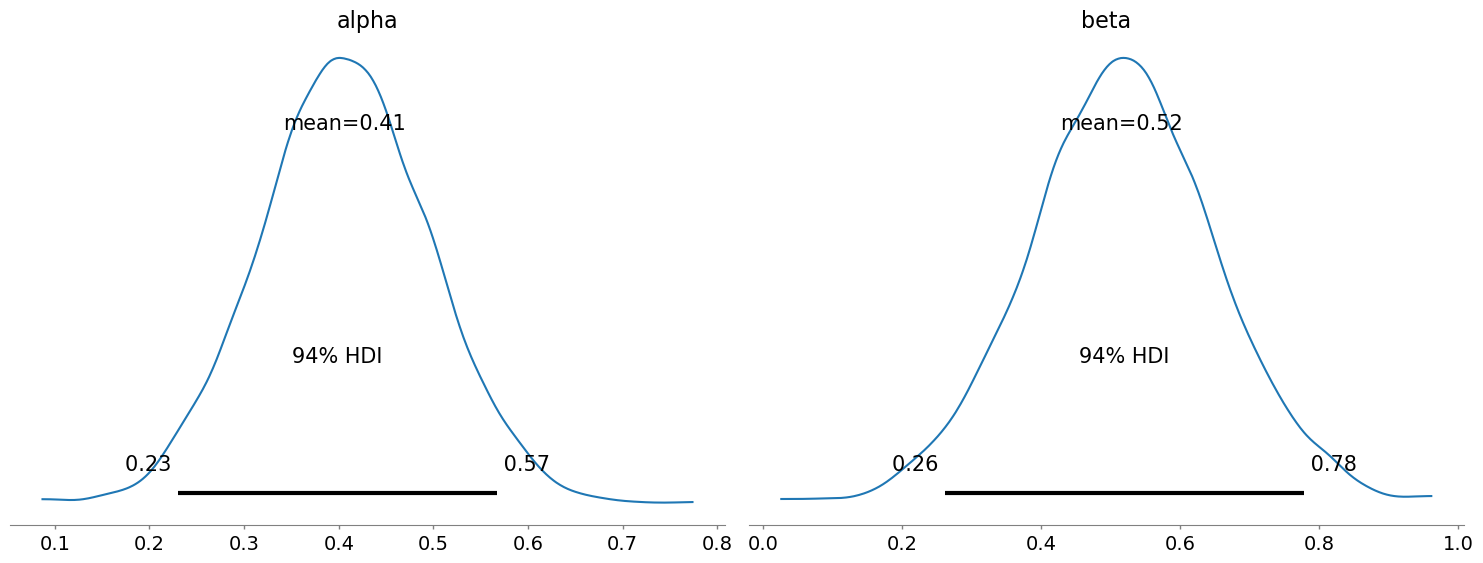

In [6]:
# Define the exponential smoothing model with Bayesian priors
with pm.Model() as exponential_smoothing_model:
    alpha = pm.Beta('alpha', alpha=1, beta=1)
    beta = pm.Beta('beta', alpha=1, beta=1)
    y = pm.AR('y', [alpha, (1 - alpha) * beta, (1 - alpha) * (1 - beta)], sigma=noise_std_dev, observed=synthetic_data)

    # Sample from the posterior distribution
    trace = pm.sample(2000, tune=1000, target_accept=0.95, random_seed=42)

    # Compute the posterior mean for alpha and beta
    alpha_mean = np.mean(trace['alpha'])
    beta_mean = np.mean(trace['beta'])

    # Plot posterior distributions for alpha and beta
    pm.plot_posterior(trace, var_names=['alpha', 'beta'])


In [7]:
# Print the summary of the trace
pm.summary(trace).round(2)


/home/m/miniconda3/envs/ThinkBayes2/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.41,0.09,0.23,0.57,0.0,0.0,4028.0,3559.0,1.0
beta,0.52,0.14,0.26,0.78,0.0,0.0,3571.0,3431.0,1.0


In [8]:
import seaborn as sns

# Choose a specific timestep for the posterior predictive distribution
timestep = 30

# Generate posterior predictive samples
posterior_predictive_samples = np.zeros((len(trace['alpha']), n_data_points))
for i, (alpha_sample, beta_sample) in enumerate(zip(trace['alpha'], trace['beta'])):
    posterior_predictive_samples[i, 0] = synthetic_data[0]
    for t in range(1, n_data_points):
        posterior_predictive_samples[i, t] = alpha_sample * synthetic_data[t - 1] + (1 - alpha_sample) * (posterior_predictive_samples[i, t - 1] + 
        beta_sample * (posterior_predictive_samples[i, t - 1] - posterior_predictive_samples[i, t - 2]))

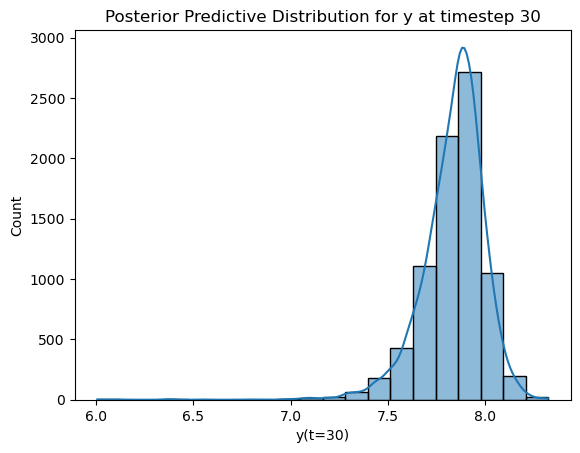

In [9]:
timestep = 30

sns.histplot(posterior_predictive_samples[:,timestep], kde=True, bins=20)
plt.xlabel('y(t={})'.format(timestep))
plt.title('Posterior Predictive Distribution for y at timestep {}'.format(timestep))
plt.show()



### Exponential smoothing with trend and level

/tmp/ipykernel_24836/3352871550.py:11: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [trend, level, beta, alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 323 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7831304267819124, but should be close to 0.95. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.8688981827569154, but should be close to 0.95. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8337745211555808, but should be close to 0.95. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_t

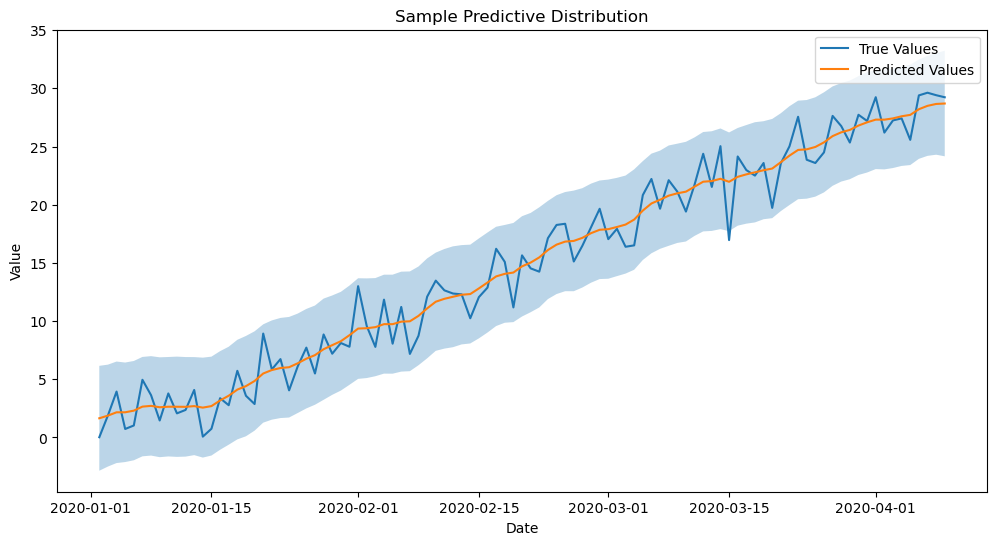

In [10]:
# Define the exponential smoothing model with Bayesian priors
with pm.Model() as exponential_smoothing_model:
    alpha = pm.Beta('alpha', alpha=1, beta=1)
    beta = pm.Beta('beta', alpha=1, beta=1)
    level = pm.GaussianRandomWalk('level', sigma=alpha, shape=n_data_points)
    trend = pm.GaussianRandomWalk('trend', sigma=beta * (1 - alpha), shape=n_data_points)
    y_obs = pm.Normal('y_obs', mu=level[:-1] + trend[:-1], sigma=noise_std_dev, observed=synthetic_data[1:])

# Sample from the posterior distribution
with exponential_smoothing_model:
    trace = pm.sample(2000, tune=1000, target_accept=0.95, random_seed=42)

# Generate sample predictive distribution
with exponential_smoothing_model:
    pp_trace = pm.sample_posterior_predictive(trace, var_names=['y_obs'])

# Plot the sample predictive distribution using Seaborn
y_pred = pp_trace['y_obs'].mean(axis=0)
y_pred_std = pp_trace['y_obs'].std(axis=0)

plt.figure(figsize=(12, 6))
sns.lineplot(x=date_range[1:], y=synthetic_data[1:], label='True Values')
sns.lineplot(x=date_range[1:], y=y_pred, label='Predicted Values')
plt.fill_between(date_range[1:], y_pred - 1.96 * y_pred_std, y_pred + 1.96 * y_pred_std, alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Sample Predictive Distribution')
plt.legend()
plt.show()